In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -U spacy==2.3.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 5.0 MB/s 
     |████████████████████████████████| 211 kB 62.6 MB/s 
     |████████████████████████████████| 1.1 MB 42.5 MB/s 
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.5
    Uninstalling srsly-2.4.5:
      Successfully uninstalled srsly-2.4.5
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.5
    Uninstalling thinc-8.1.5:
      Successfully uninstalled thinc-8.1.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.3
    Uninstalling spacy-3.4.3:
      Successfully uninstalled spacy-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

In [ ]:
!unzip /content/gdrive/MyDrive/movie_review_dataset/movie_review_data.zip -d .

Archive:  /content/gdrive/MyDrive/movie_review_dataset/movie_review_data.zip
   creating: ./movie_review_data/
  inflating: ./movie_review_data/movie_review_dataset.csv  


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import string
from sklearn.metrics import accuracy_score, f1_score


## Dataset Preparation

In [2]:
df= pd.read_csv("/content/movie_review_data/movie_review_dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


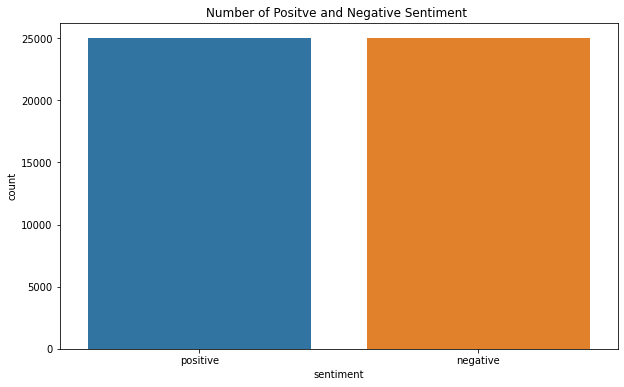

In [5]:
plt.figure(figsize = (10,6))
plt.title("Number of Positve and Negative Sentiment ")
sns.countplot(x = "sentiment", data = df)

plt.show()

In [6]:
df['lenght'] = df['review'].apply(lambda x : len(x.split()))

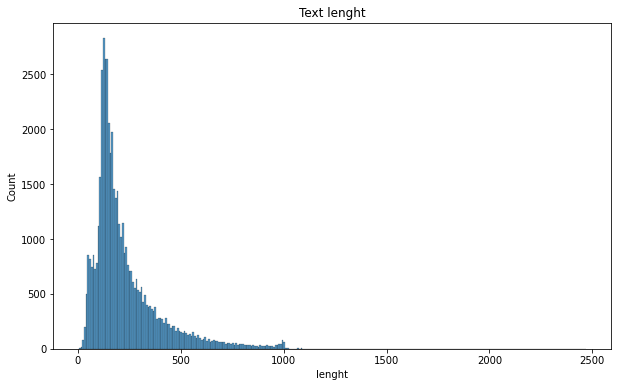

In [7]:
plt.figure(figsize = (10,6))
plt.title("Text lenght")

sns.histplot(x="lenght", data = df)
plt.show()

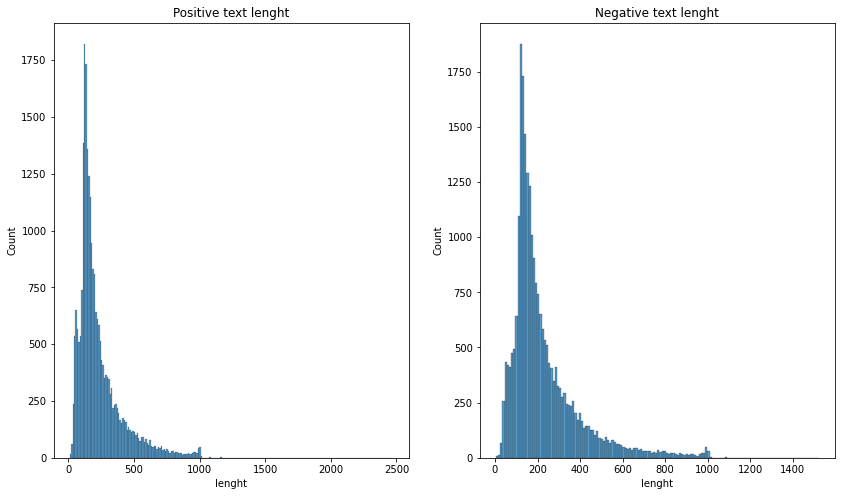

In [8]:
fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(121)
plt.title("Positive text lenght")
sns.histplot(x="lenght", data = df[df['sentiment'] == 'positive'], ax=ax1)

ax2 = fig.add_subplot(122)
plt.title("Negative text lenght")
sns.histplot(x="lenght", data = df[df['sentiment'] == 'negative'], ax=ax2)

plt.show()

# Pre-Processing-Text Preprocessing

In [9]:
def text_preprocess(text):
    clean_text = re.sub('<br\s?\/>|<br>', '', text) 
    clean_text = re.sub('[^a-zA-Z\']', ' ', clean_text)
    clean_text = clean_text.lower()
    return clean_text

In [10]:
df['review'] = df['review'].apply(lambda x : text_preprocess(x))
df.iloc[1,0]

"a wonderful little production  the filming technique is very unassuming  very old time bbc fashion and gives a comforting  and sometimes discomforting  sense of realism to the entire piece  the actors are extremely well chosen  michael sheen not only  has got all the polari  but he has all the voices down pat too  you can truly see the seamless editing guided by the references to williams' diary entries  not only is it well worth the watching but it is a terrificly written and performed piece  a masterful production about one of the great master's of comedy and his life  the realism really comes home with the little things  the fantasy of the guard which  rather than use the traditional 'dream' techniques remains solid then disappears  it plays on our knowledge and our senses  particularly with the scenes concerning orton and halliwell and the sets  particularly of their flat with halliwell's murals decorating every surface  are terribly well done "

In [11]:
# Splitting the data into train set and validation set
train_data = df[:30000]
val_data = df[30000:45000]
test_data=df[45000:]

Model Implementing

In [15]:
import spacy

# Create an empty model
nlp = spacy.blank("en")

# Create custom TextCategorizer with exclusive classes and bag of words architecture
textcat = nlp.create_pipe("textcat", config={"exclusive_classes": True, "architecture": "bow"})

# Add the TextCategorizer to the empty model
nlp.add_pipe(textcat)
textcat.add_label("positive")
textcat.add_label("negative")

1

In [16]:
# Data Preparation
train_texts = train_data['review'].values
train_labels = [{'cats': {'positive': label == 'positive','negative': label == 'negative'}} 
                for label in train_data['sentiment']]

# Training

In [17]:
from spacy.util import minibatch
import random

def model_train(model, train, optimizer):
    losses = {}
    random.seed(1)
    random.shuffle(train)
    
    batches = minibatch(train, size=8)
    for batch in batches:
        texts, labels = zip(*batch)
        model.update(texts, labels, sgd=optimizer, losses=losses)
        
    return losses

In [18]:
# 1st Iteration
spacy.util.fix_random_seed(1)
random.seed(1)
optimizer = nlp.begin_training()
train = list(zip(train_texts, train_labels))
losses = model_train(nlp, train, optimizer)
print(losses['textcat'])

13.035159226577797


# Validation

In [19]:
mapper = {'positive':1, 'negative':0}
val_data['sentiment'] = val_data['sentiment'].apply(lambda x : mapper[x])
val_data.sentiment.values

<ipython-input-19-db2a64ee85f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['sentiment'] = val_data['sentiment'].apply(lambda x : mapper[x])


array([1, 0, 0, ..., 1, 1, 0])

In [20]:
def evaluate(model, texts, labels): 
    predicted_class = predict(model, texts)
    accuracy = accuracy_score(predicted_class, labels)
    fscore = f1_score(predicted_class, labels)
    return accuracy, fscore

In [23]:
accuracy, f1score = evaluate(nlp, list(val_data.review.values), val_data.sentiment.values)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1_score: {f1score:.4f}")

Accuracy: 0.8791
F1_score: 0.8782


# Prediction

In [22]:
# Predict list of reviews
def predict(nlp, texts): 

    docs = [nlp.tokenizer(text) for text in texts]    
    # Use textcat to get the scores for each doc
    textcat = nlp.get_pipe('textcat')
    predicted_class = textcat.predict(docs)[0].argmin(axis=1)
    
    return predicted_class

In [35]:
Input_data=input("Enter the input:")
# Input_data=text_preprocess(Input_data)
labels=["Negative","Positive"]
prediction=predict(nlp,[Input_data])
print("Predicted sentiment is:",labels[prediction[0]])

Enter the input:Input_data=text_preprocess(Input_data)
Predicted sentiment is: Positive
